In [3]:
import os
import glob
import wfdb
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

from skorch import NeuralNetRegressor
from torch.utils.data import Dataset, DataLoader
from skimage.restoration import denoise_wavelet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_directory = "./data/CEBS/m001"
sampling_rate = '10L' # 10ms https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
target_snr_dbs = [0.5, 2, 10]

segment_size = '10240L'
segment_size_seconds = int(pd.to_timedelta(segment_size).total_seconds())
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())

#num_epochs = 1024
#batch_size = 64
#learning_rate = 0.001
#weight_decay = 0.01

In [31]:
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / np.sum((signal_clean - signal_noisy) ** 2))

def psnr(signal_clean, signal_noisy):
    return 20 * np.log10(np.max(signal_clean) / np.sqrt(mse(signal_clean, signal_noisy)))

def xcorr(signal_clean, signal_noisy):
    return np.correlate(signal_clean, signal_noisy, mode='same')

In [6]:
def load_dataset(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    frequency = metadata['fs']
    column_names = metadata['sig_name']
    length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)
    data = data.resample(sampling_rate).mean().SCG

    data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
    data = data[data.apply(lambda x: len(x) == segment_size_samples)]
    data = data.apply(lambda x: np.array(x))
    
    return data

In [7]:
def load_datasets(directory):

    filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*m[0-9][0-9][0-9].*')]))
    data = pd.concat((load_dataset(filename) for filename in filenames), ignore_index=True)

    return data

data = load_datasets('./data/CEBS/')

In [8]:
def add_gaussian(data, target_snr_dbs):

    target_snr_db = random.choice(target_snr_dbs)

    data_watts = data ** 2
    data_avg_watts = np.mean(data_watts)
    data_avg_db = 10 * np.log10(data_avg_watts)

    noise_avg_db = data_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

    data_noisy = data + noise
    return data_noisy

def normalize(x, min_val, max_val):
    y = (x-min_val) / (max_val - min_val)
    return y

In [9]:
class SCGData(Dataset):

    def __init__(self, transform=None):

        self.min_val = 0
        self.max_val = np.inf

        data = load_datasets('./data/CEBS/')
        #data = data.resample(sampling_rate).mean().SCG

        #data_noisy = add_gaussian(data, target_snr_db)
        data_noise = data.apply(lambda x: add_gaussian(x, target_snr_dbs)) # maybe randomly apply different noise levels to parts of data --> generalization, maybe prove this with experiment
        data = pd.DataFrame({'clean': data, 'noise': data_noise})

        data_concat = np.concatenate([np.concatenate(data.values[0]), np.concatenate(data.values[1])])
        # https://www.geeksforgeeks.org/data-normalization-with-pandas/
        self.min_val = np.min(data.values.tolist())
        self.max_val = np.max(data.values.tolist())

        for column in data.columns:
            data[column] = data[column].apply(lambda x: normalize(x, self.min_val, self.max_val))
            # data[column] = (data[column] - self.min_val) / (self.max_val - self.min_val)

        #data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        #data = data[data['clean'].apply(lambda x: len(x) == segment_size_samples)]
        #data['clean'] = data['clean'].apply(lambda x: np.array(x))
        #data['noise'] = data['noise'].apply(lambda x: np.array(x))
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.transform = transform
        self.n_samples = data.shape[0]

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples


class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

In [23]:
dataset = SCGData(transform=ToTensor())

In [11]:
# print(dataset.x_data)
print(max(np.concatenate([np.concatenate(dataset.x_data), np.concatenate(dataset.y_data)])))

1.0


In [12]:
def load_data():
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [13]:
class DeNoise(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 16, stride=2),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/2), 16, stride=2),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/2), int(layer_size/4), 16, stride=2),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), 1, 16, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/4), 16, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size/2), 16, stride=2, output_padding=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/2), layer_size, 16, stride=2, output_padding=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.ConvTranspose1d(layer_size, 1, 16, stride=2, padding=0), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 16, stride=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//8)
        #encoded = nn.functional.pad(encoded, (0, 0, 0, 0))
        decoded = self.decoder(encoded)
        return decoded

print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*8) + 7)
torchinfo.summary(DeNoise(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
71.0


/home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise                                  [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 100]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 505]
│    └─BatchNorm1d: 2-2                  [32, 128, 505]            [32, 128, 505]
│    └─ELU: 2-3                          [32, 128, 505]            [32, 128, 505]
│    └─Conv1d: 2-4                       [32, 128, 505]            [32, 64, 245]
│    └─BatchNorm1d: 2-5                  [32, 64, 245]             [32, 64, 245]
│    └─ELU: 2-6                          [32, 64, 245]             [32, 64, 245]
│    └─Conv1d: 2-7                       [32, 64, 245]             [32, 32, 115]
│    └─BatchNorm1d: 2-8                  [32, 32, 115]             [32, 32, 115]
│    └─ELU: 2-9                          [32, 32, 115]             [32, 32, 115]
│    └─Conv1d: 2-10        

In [14]:
class DeNoise2D(nn.Module):
    def __init__(self, kernel_size=16, filters_1=64, filters_2=32):
        super(DeNoise2D, self).__init__()
        #self.p1 = segment_size_samples/2 + 7
        #self.p2 = segment_size_samples/64 + 7
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.kernel_size = kernel_size
        self.filters_1 = filters_1
        self.filters_2 = filters_2

        self.encoder = nn.Sequential(
            nn.Conv1d(1, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, filters_1, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.ConvTranspose1d(filters_1, filters_2, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, output_padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_1, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        # x = x.view(-1, 1, segment_size_samples)
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//16, 1)
        #encoded = nn.functional.pad(encoded, (0, 0, 1, 0))
        decoded = self.decoder(encoded)
        return decoded


print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*16) + 7)
torchinfo.summary(DeNoise2D(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
39.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2D                                [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 3]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 64, 505]
│    └─BatchNorm1d: 2-2                  [32, 64, 505]             [32, 64, 505]
│    └─ELU: 2-3                          [32, 64, 505]             [32, 64, 505]
│    └─Conv1d: 2-4                       [32, 64, 505]             [32, 32, 245]
│    └─BatchNorm1d: 2-5                  [32, 32, 245]             [32, 32, 245]
│    └─ELU: 2-6                          [32, 32, 245]             [32, 32, 245]
│    └─Conv1d: 2-7                       [32, 32, 245]             [32, 32, 115]
│    └─BatchNorm1d: 2-8                  [32, 32, 115]             [32, 32, 115]
│    └─ELU: 2-9                          [32, 32, 115]             [32, 32, 115]
│    └─Conv1d: 2-10             

In [15]:
class DeNoise2(nn.Module):
    def __init__(self):
        super(DeNoise2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 32),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

torchinfo.summary(DeNoise2(), (64, 1, 1024), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [64, 1, 1024]             [64, 1, 1024]
├─Sequential: 1-1                        [64, 1, 1024]             [64, 1, 32]
│    └─Linear: 2-1                       [64, 1, 1024]             [64, 1, 512]
│    └─BatchNorm1d: 2-2                  [64, 1, 512]              [64, 1, 512]
│    └─Dropout: 2-3                      [64, 1, 512]              [64, 1, 512]
│    └─ReLU: 2-4                         [64, 1, 512]              [64, 1, 512]
│    └─Linear: 2-5                       [64, 1, 512]              [64, 1, 256]
│    └─BatchNorm1d: 2-6                  [64, 1, 256]              [64, 1, 256]
│    └─Dropout: 2-7                      [64, 1, 256]              [64, 1, 256]
│    └─ReLU: 2-8                         [64, 1, 256]              [64, 1, 256]
│    └─Linear: 2-9                       [64, 1, 256]              [64, 1, 128]
│    └─BatchNorm1d: 2-10                

In [16]:
def train(config, train_dataset, model_num, is_tune=False, checkpoint_dir=None, data_dir=None):

    if model_num == 1:
        model = DeNoise(layer_size=config['layer_size'])
    else:
        model = DeNoise2D(filters_1=config['layer_size'], filters_2=int(config['layer_size']/2))
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.99), weight_decay=config['wd'])

    if checkpoint_dir != None:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    test_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - test_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

    n_total_steps = len(train_loader)
    min_val_loss = np.inf

    for epoch in range(num_epochs):
        train_loss = 0.0
        epoch_steps = 0
        for i, (inputs, lables) in enumerate(train_loader):
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1

            #if (i + 1) % 50 == 0:
            #    print(f'epoch {epoch + 1} / {num_epochs}, step {i + 1} / {n_total_steps}, loss = {loss.item():.10f}')

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (inputs, lables) in enumerate(val_loader):
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            output = model(inputs)
            #_, predicted = torch.max(output.data, 1)
            #total += lables.size(0)
            #correct += (predicted == lables).sum().item()

            loss = criterion(output, lables)
            val_loss += loss.item()
            val_steps += 1

        if is_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(loss=(val_loss / val_steps))
        else:
            print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
            if min_val_loss > val_loss:
                print(f'\tval loss decreased from {min_val_loss:.10f} to {val_loss:.10f}')
                min_val_loss = val_loss
            
                torch.save(model.state_dict(), 'model.pth')

In [17]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

num_samples = 64 # sample data multiple times
max_num_epochs = 124

config = {
    'lr': tune.loguniform(1e-6, 1e-3),
    'wd': tune.loguniform(1e-6, 1e-3),
    'batch_size': tune.choice([16, 32, 64]),
    'layer_size': tune.choice([64, 128, 256])
}

train_dataset, test_dataset = load_data()
scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=1, reduction_factor=2)
reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
result = tune.run(
    partial(train, train_dataset, model_num=1, is_tune=True, checkpoint_dir=None, data_dir=None),
    resources_per_trial={'cpu': 4, 'gpu': 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial('loss', 'min', 'last')
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
# print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

best_trained_model =  DeNoise2D().to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
# best_trained_model.load_state_dict(model_state)

2022-11-03 10:26:29,462	INFO worker.py:1518 -- Started a local Ray instance.


KeyboardInterrupt: 

In [33]:
num_epochs = 10000

# {'lr': 0.0006318157059655015, 'wd': 3.3629617758754896e-05, 'batch_size': 64, 'layer_size': 256} 1.2362915564760139e-06
# {'lr': 0.00048183509019426087, 'wd': 0.0003108590459840217, 'batch_size': 16, 'layer_size': 128} 2.7478875495035027e-05
# {'lr': 0.0008076520730650839, 'wd': 2.1683652430471918e-05, 'batch_size': 16, 'layer_size': 128} 1.9028929418239167e-06
# {'lr': 0.00028456403190240423, 'wd': 4.7763662120193e-06, 'batch_size': 16, 'layer_size': 128} 1.3478121416185252e-06

# {'lr': 1.9110838355221407e-05, 'wd': 0.0001785324161425569, 'batch_size': 8, 'layer_size': 128} 2.1693630013283712e-06
# {'lr': 0.00010542143994619722, 'batch_size': 8, 'layer_size': 64} 3.196227047628154e-06
# {'lr': 4.349163661441578e-05, 'batch_size': 16, 'layer_size': 128}

train_dataset, test_dataset = load_data()
train({'lr': 1e-04, 'wd': 0, 'layer_size': 128, 'batch_size': 8}, train_dataset, 1)
# train({'lr': 1.9e-5, 'wd': 0.000178, 'layer_size': 128, 'batch_size': 8}, 2)

epoch 1 / 10000, train loss = 0.0008827744, val loss = 0.0000897658
	val loss decreased from inf to 0.0103230703
epoch 2 / 10000, train loss = 0.0000732183, val loss = 0.0000490128
	val loss decreased from 0.0103230703 to 0.0056364703
epoch 3 / 10000, train loss = 0.0000440330, val loss = 0.0000299058
	val loss decreased from 0.0056364703 to 0.0034391625
epoch 4 / 10000, train loss = 0.0000282224, val loss = 0.0000173932
	val loss decreased from 0.0034391625 to 0.0020002218
epoch 5 / 10000, train loss = 0.0000197534, val loss = 0.0000110587
	val loss decreased from 0.0020002218 to 0.0012717454
epoch 6 / 10000, train loss = 0.0000142504, val loss = 0.0000059448
	val loss decreased from 0.0012717454 to 0.0006836509
epoch 7 / 10000, train loss = 0.0000097192, val loss = 0.0000035999
	val loss decreased from 0.0006836509 to 0.0004139845
epoch 8 / 10000, train loss = 0.0000076244, val loss = 0.0000045870
epoch 9 / 10000, train loss = 0.0000058434, val loss = 0.0000016880
	val loss decreased

KeyboardInterrupt: 

6.9659824
2.7498734

2.0996943
1.076181

0.594555139541626
4.631252288818359
2.856280207633972

13.54637861251831
17.58307695388794

[ 344.7732    216.71828    23.252907 ... -181.81699   282.25995
  511.30334 ]
[175.76506 279.54495 230.18706 ... -61.90718 184.58195 249.68596]



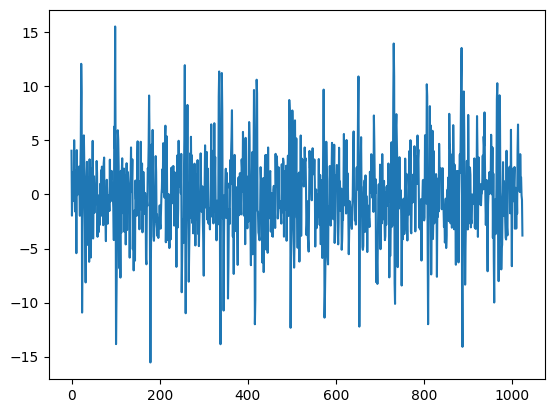

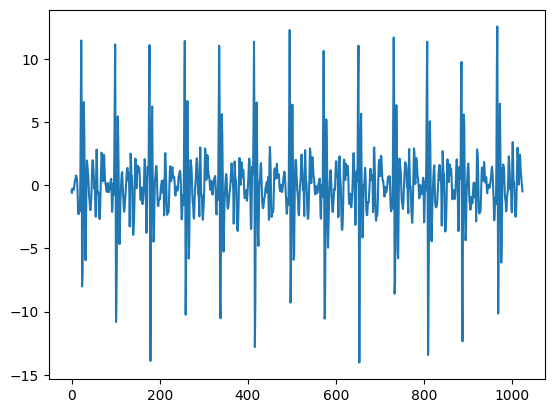

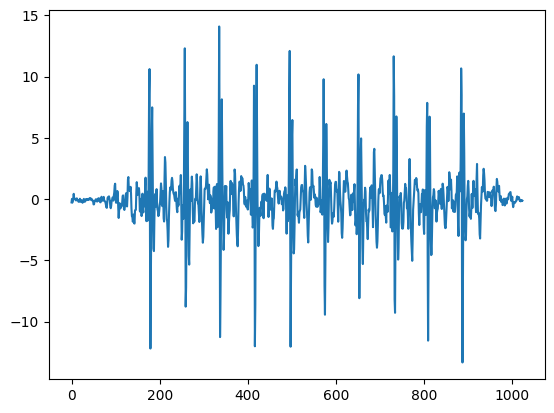

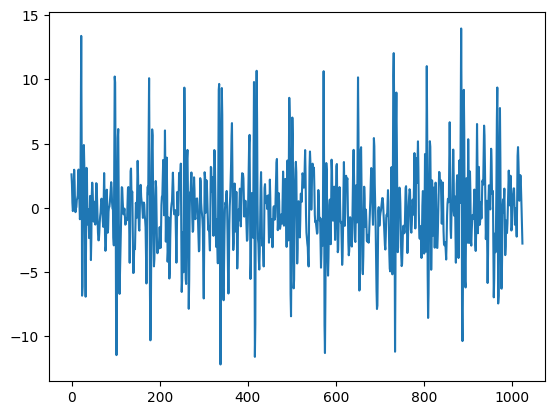

In [37]:
# model = DeNoise2D(filters_1=128, filters_2=64).to(device)
model = DeNoise(layer_size=128).to(device)
model.load_state_dict(torch.load('model.pth'))
#model.load_state_dict(model_state)
model.eval()


def reverse(x):
    return dataset.max_val * x - x * dataset.min_val + dataset.min_val

with torch.no_grad():
    
    noise = test_dataset[100][0].reshape(-1, 1, segment_size_samples).to(device)
    clean = test_dataset[100][1].reshape(-1, 1, segment_size_samples).to(device)

    predicted = model(noise).to('cpu').reshape(segment_size_samples).numpy()
    clean = clean.to('cpu').reshape(segment_size_samples).numpy()
    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
    predicted2 = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')

    noise = reverse(noise)
    clean = reverse(clean)
    predicted = reverse(predicted)
    predicted2 = reverse(predicted2)

    print(mse(clean, noise))
    print(mse(clean, predicted))
    print()

    print(mae(clean, noise))
    print(mae(clean, predicted))
    print()

    print(snr(clean, noise))
    print(snr(clean, predicted))
    print(snr(clean, predicted2))
    print()

    print(psnr(clean, noise))
    print(psnr(clean, predicted))
    print()

    print(xcorr(clean, noise))
    print(xcorr(clean, predicted))
    print()
    
    time_from = 0
    time = 1024

    plt.plot(range(time)[time_from:time], noise[time_from:time])
    plt.show()
    plt.plot(range(time)[time_from:time], clean[time_from:time])
    plt.show()
    plt.plot(range(time)[time_from:time], predicted[time_from:time])
    plt.show()
    plt.plot(range(time)[time_from:time], predicted2[time_from:time])
    plt.show()
    
    torch.cuda.empty_cache()